# Mutual Information: gen_forecast_da vs Load Forecast (Option 3: Seasonal Lags)

This notebook investigates the relationship between `gen_forecast_da` (target) and `load_forecast_da` (feature) using
mutual information at key seasonal lags (daily, weekly, yearly).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression


In [5]:
# Load merged hourly dataset
df = pd.read_csv("../../data_cleaned/merged/Merge_all_prices_load_gen_res.csv")
df.head()


,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act
0,2015-01-04,2015,1,4,4,23,1,6,22.34,2015-01-04 23:00:00,...,192.125,478.0200,11675.5250,14223.2775,0.0,0.1700,NaN,57028.5925,11867.6500,14701.4675
1,2015-01-05,2015,1,5,5,0,2,0,17.93,2015-01-05 00:00:00,...,192.375,468.5525,11924.5575,14207.5025,0.0,0.2075,NaN,56318.8525,12116.9325,14676.2625
2,2015-01-05,2015,1,5,5,1,2,0,15.17,2015-01-05 01:00:00,...,195.000,465.5550,12000.4075,14439.8025,0.0,0.1800,NaN,56216.6000,12195.4075,14905.5375
3,2015-01-05,2015,1,5,5,2,2,0,16.38,2015-01-05 02:00:00,...,193.625,454.0175,12108.2650,14584.6825,0.0,0.2000,NaN,56394.7350,12301.8900,15038.9000
4,2015-01-05,2015,1,5,5,3,2,0,17.38,2015-01-05 03:00:00,...,187.625,457.4750,12196.1175,15071.2450,0.0,0.1950,NaN,57670.7700,12383.7425,15528.9150


In [6]:
# Convert timestamp columns to datetime
df["period_start_utc"] = pd.to_datetime(df["period_start_utc"], utc=True, errors="coerce")
df["period_end_utc"] = pd.to_datetime(df["period_end_utc"], utc=True, errors="coerce")

# Optional: convert date column if needed
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

df[["period_start_utc", "period_end_utc"]].head()


,period_start_utc,period_end_utc
0,2015-01-04 23:00:00+00:00,2015-01-05 00:00:00+00:00
1,2015-01-05 00:00:00+00:00,2015-01-05 01:00:00+00:00
2,2015-01-05 01:00:00+00:00,2015-01-05 02:00:00+00:00
3,2015-01-05 02:00:00+00:00,2015-01-05 03:00:00+00:00
4,2015-01-05 03:00:00+00:00,2015-01-05 04:00:00+00:00


In [7]:
# Basic cleaning and sorting
df["gen_forecast_da"] = pd.to_numeric(df["gen_forecast_da"], errors="coerce")
df["load_forecast_da"] = pd.to_numeric(df["load_forecast_da"], errors="coerce")
df = df.sort_values("period_start_utc")

df[["gen_forecast_da", "load_forecast_da"]].isna().sum()


gen_forecast_da     32738
load_forecast_da     1107
dtype: int64

In [8]:
# Option 3: Evaluate MI at seasonal lags (hourly data)
# Daily: 24, Weekly: 168, Yearly: 8760 (use 8784 for leap years)
seasonal_lags = [0, 1, 24, 48, 168, 336, 8760]

def mi_for_lags(data, target_col, feature_col, lags, n_neighbors=5, random_state=42):
    rows = []
    for k in lags:
        x = data[feature_col].shift(k)
        y = data[target_col]
        tmp = pd.DataFrame({"x": x, "y": y}).dropna()
        if len(tmp) < 1000:
            continue
        mi = mutual_info_regression(
            tmp[["x"]], tmp["y"], n_neighbors=n_neighbors, random_state=random_state
        )[0]
        rows.append({"lag": k, "mi": float(mi), "n": len(tmp)})
    return pd.DataFrame(rows)

mi_results = mi_for_lags(df, target_col="gen_forecast_da", feature_col="load_forecast_da", lags=seasonal_lags)
mi_results


,lag,mi,n
0,0,0.535928,62686
1,1,0.500003,62684
2,24,0.338414,62682
3,48,0.214038,62660
4,168,0.437520,62588
5,336,0.406929,62491
6,8760,0.312511,62491


,lag,mi,n
0,0,0.535928,62686
1,1,0.500003,62684
4,168,0.437520,62588
5,336,0.406929,62491
2,24,0.338414,62682
6,8760,0.312511,62491
3,48,0.214038,62660


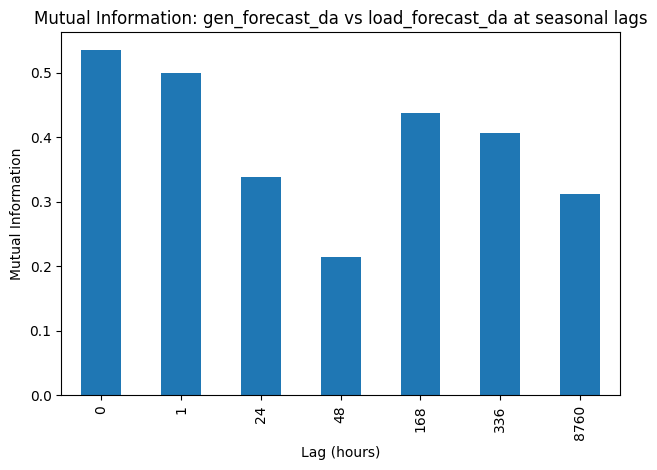

In [9]:
# Plot MI by lag
if not mi_results.empty:
    ax = mi_results.plot(x="lag", y="mi", kind="bar", legend=False)
    ax.set_title("Mutual Information: gen_forecast_da vs load_forecast_da at seasonal lags")
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Mutual Information")
    plt.tight_layout()

mi_results.sort_values("mi", ascending=False)


In [10]:
# # Option 1: Scan a wider lag range to find informative lags
# max_lag = 336  # two weeks of hourly lags
# scan_lags = list(range(1, max_lag + 1))

# mi_scan = mi_for_lags(df, target_col="gen_forecast_da", feature_col="load_forecast_da", lags=scan_lags)

# # Show top lags by MI
# mi_scan.sort_values("mi", ascending=False).head(15)


In [11]:
# # Plot MI over the scanned lag range
# if not mi_scan.empty:
#     ax = mi_scan.plot(x="lag", y="mi", kind="line", legend=False, figsize=(10, 4))
#     ax.set_title("MI Scan: gen_forecast_da vs load_forecast_da")
#     ax.set_xlabel("Lag (hours)")
#     ax.set_ylabel("Mutual Information")
#     plt.tight_layout()


In [12]:
# Option 2: Normalized Mutual Information (NMI) with discretization
from sklearn.metrics import normalized_mutual_info_score

def _discretize(series, bins=20):
    s = series.dropna()
    # quantile-based bins; fall back to regular bins if needed
    try:
        return pd.qcut(s, q=bins, duplicates="drop").astype(str)
    except ValueError:
        return pd.cut(s, bins=bins).astype(str)

def nmi_for_lags(data, target_col, feature_col, lags, bins=20):
    rows = []
    for k in lags:
        x = data[feature_col].shift(k)
        y = data[target_col]
        tmp = pd.DataFrame({"x": x, "y": y}).dropna()
        if len(tmp) < 1000:
            continue
        x_binned = _discretize(tmp["x"], bins=bins)
        y_binned = _discretize(tmp["y"], bins=bins)
        # align indices after discretization
        aligned = pd.concat([x_binned, y_binned], axis=1).dropna()
        nmi = normalized_mutual_info_score(aligned.iloc[:, 0], aligned.iloc[:, 1])
        rows.append({"lag": k, "nmi": float(nmi), "n": len(aligned)})
    return pd.DataFrame(rows)

nmi_results = nmi_for_lags(df, target_col="gen_forecast_da", feature_col="load_forecast_da", lags=seasonal_lags, bins=20)
nmi_results


,lag,nmi,n
0,0,0.170447,62686
1,1,0.160352,62684
2,24,0.109271,62682
3,48,0.069168,62660
4,168,0.141538,62588
5,336,0.131870,62491
6,8760,0.101142,62491


,lag,nmi,n
0,0,0.170447,62686
1,1,0.160352,62684
4,168,0.141538,62588
5,336,0.131870,62491
2,24,0.109271,62682
6,8760,0.101142,62491
3,48,0.069168,62660


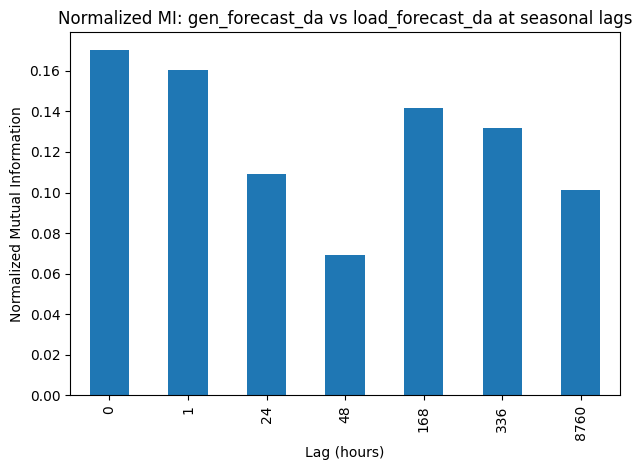

In [13]:
# Plot NMI by lag
if not nmi_results.empty:
    ax = nmi_results.plot(x="lag", y="nmi", kind="bar", legend=False)
    ax.set_title("Normalized MI: gen_forecast_da vs load_forecast_da at seasonal lags")
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Normalized Mutual Information")
    plt.tight_layout()

nmi_results.sort_values("nmi", ascending=False)
